In [1]:
#make sure your path is set to source folder
%cd /Users/I500955/Documents/PG/MLOPs/Assignment/02_training_pipeline/notebooks

/Users/I500955/Documents/PG/MLOPs/Assignment/02_training_pipeline/notebooks


In [2]:
!pwd

/Users/I500955/Documents/PG/MLOPs/Assignment/02_training_pipeline/notebooks


In [3]:
%ls

Data/
lead_scoring_model_experimentation.ipynb
logs.log


### 1 : Importing Libraries

In [4]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install scikit-optimize
!pip install ydata-profiling
!pip install mlflow
!pip install pycaret
!pip install 'pycaret[tuners]'
!pip install --upgrade pandas "dask[complete]"
!pip install optuna

  Using cached pandas-2.2.2-cp310-cp310-macosx_10_9_x86_64.whl (12.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.2 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.2 which is incompatible.


In [6]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

import sys
import os
sys.path.append(os.path.abspath('/Users/I500955/Documents/PG/MLOPs/Assignment'))
from scripts import utils

 ### 2 Reading Data

In [7]:


##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')
dataset.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


(238964, 13)

In [8]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [9]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [10]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

utils.create_sqlit_connection('/Users/I500955/Documents/PG/MLOPs/Assignment/02_training_pipeline/notebooks/',r"lead_scoring_model_experimentation.db")

/Users/I500955/Documents/PG/MLOPs/Assignment/02_training_pipeline/notebooks/
2.6.0
DB Created


In [11]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [12]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [13]:
# setup pycaret 

data_for_model, data_unseen = utils.get_validation_unseen_set(dataset, validation_frac=0.05, sample=False, sample_frac=0.1)
print('Data for Modeling: ' + str(data_for_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (227016, 12)
Unseen Data For Predictions: (11948, 12)


### 4 : Model Experimentation with pycaret

In [14]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
exp01 = setup(data=data_for_model, target = 'app_complete_flag', 
                   session_id = 123,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='codepro_model_exp01',
                   log_plots=True, log_data=True,
                   #silent=True, 
                   verbose=True,
                   log_profile=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(227016, 12)"
4,Transformed data shape,"(227016, 44)"
5,Transformed train set shape,"(158911, 44)"
6,Transformed test set shape,"(68105, 44)"
7,Numeric features,8
8,Categorical features,3
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
2024/08/18 00:53:51 INFO mlflow.tracking.fluent: Experiment with name 'codepro_model_exp01' does not exist. Creating a new experiment.


In [15]:
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5002,0.4989,0.5447,0.5021,0.5224,0.0000,0.0000,5.7000
nb,Naive Bayes,0.4997,0.4989,0.3942,0.5080,0.2702,0.0003,0.0013,1.4200
et,Extra Trees Classifier,0.4997,0.4988,0.5305,0.5017,0.5154,-0.0008,-0.0008,5.8720
dt,Decision Tree Classifier,0.4996,0.4984,0.5302,0.5016,0.5152,-0.0012,-0.0012,1.8200
lr,Logistic Regression,0.4995,0.4985,0.6171,0.5012,0.5528,-0.0021,-0.0021,2.2340
lightgbm,Light Gradient Boosting Machine,0.4991,0.4995,0.6125,0.5009,0.5508,-0.0028,-0.0029,1.6720
ridge,Ridge Classifier,0.4987,0.4978,0.6167,0.5006,0.5524,-0.0035,-0.0036,1.4020
lda,Linear Discriminant Analysis,0.4987,0.4978,0.6167,0.5006,0.5524,-0.0035,-0.0036,2.3740


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

2024/08/18 00:57:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 00:57:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://0.0.0.0:6006/#/experiments/1/runs/d2bf9c53e8144bcb8a882b142595db23.
2024/08/18 00:57:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/1.
2024/08/18 00:57:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 00:57:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run Naive Bayes at: http://0.0.0.0:6006/#/experiments/1/runs/147fac55ee9945a992d6889223a49b3d.
2024/08/18 00:57:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/1.
2024/08/18 00:57:19 WARNING mlflow.models.model: Input ex

In [16]:
# create a model which gives the highest accuracy
rf  = create_model('rf', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5016,0.4994,0.5294,0.5035,0.5161,0.0029,0.0029
1,0.5025,0.5022,0.5643,0.5041,0.5325,0.0044,0.0044
2,0.5031,0.5011,0.5478,0.5047,0.5254,0.0057,0.0057
3,0.4964,0.4948,0.5665,0.4987,0.5305,-0.0077,-0.0078
4,0.4975,0.4971,0.5155,0.4996,0.5074,-0.0053,-0.0053
Mean,0.5002,0.4989,0.5447,0.5021,0.5224,0.0000,0.0000
Std,0.0027,0.0027,0.0198,0.0025,0.0094,0.0054,0.0055


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2024/08/18 00:58:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 00:58:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://0.0.0.0:6006/#/experiments/1/runs/809cf95315d04e719503ea7e85dbb8fc.
2024/08/18 00:58:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/1.


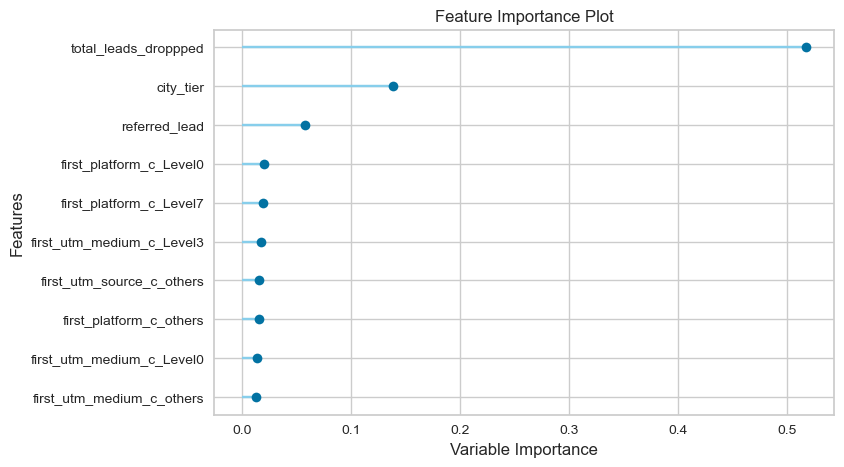

In [17]:
# create feature importance plot
plot_model(best_model, plot='feature')

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [18]:
features = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']

data_for_model_2, data_unseen_2 = utils.get_validation_unseen_set(dataset[features], validation_frac=0.05, sample=False, sample_frac=0.1)
print('Data for Modeling: ' + str(data_for_model_2.shape))
print('Unseen Data For Predictions: ' + str(data_unseen_2.shape))

Data for Modeling: (227016, 7)
Unseen Data For Predictions: (11948, 7)


In [19]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

exp02 = setup(data=data_for_model_2, target='app_complete_flag', 
               normalize=False, 
               transformation=False, 
               fix_imbalance=False,
               n_jobs=-1, 
               use_gpu=True, 
               log_experiment=True,
               experiment_name='codepro_model_exp02',
               log_plots=True, 
               log_data=True,
               verbose=True, 
               log_profile=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,3263
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(227016, 7)"
4,Transformed data shape,"(227016, 39)"
5,Transformed train set shape,"(158911, 39)"
6,Transformed test set shape,"(68105, 39)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
2024/08/18 00:59:11 INFO mlflow.tracking.fluent: Experiment with name 'codepro_model_exp02' does not exist. Creating a new experiment.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

In [20]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model_2 = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5010,0.4995,0.5632,0.5028,0.5310,0.0014,0.0014,1.6020
lr,Logistic Regression,0.5009,0.5007,0.6128,0.5025,0.5519,0.0008,0.0008,1.4960
ridge,Ridge Classifier,0.5007,0.5008,0.6121,0.5023,0.5517,0.0005,0.0005,1.2360
lda,Linear Discriminant Analysis,0.5007,0.5008,0.6141,0.5023,0.5525,0.0005,0.0005,2.1620
nb,Naive Bayes,0.5006,0.5016,0.4115,0.5031,0.4469,0.0019,0.0019,1.3760
et,Extra Trees Classifier,0.5000,0.4999,0.5163,0.5020,0.5090,-0.0002,-0.0002,5.4520
dt,Decision Tree Classifier,0.4998,0.4997,0.5158,0.5019,0.5087,-0.0005,-0.0005,1.5300
rf,Random Forest Classifier,0.4990,0.4992,0.5253,0.5010,0.5128,-0.0023,-0.0023,4.9160


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

2024/08/18 01:01:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 01:01:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://0.0.0.0:6006/#/experiments/2/runs/7720e3e5db054959be6fa24f2be1f003.
2024/08/18 01:01:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/2.
2024/08/18 01:01:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 01:01:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://0.0.0.0:6006/#/experiments/2/runs/29da9df59f3e46a4b2c3de4a34d98257.
2024/08/18 01:01:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/2.
2024/08/18 01:01:09 WARNING mlflow.models.

In [21]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5008,0.5017,0.5948,0.5025,0.5448,0.0009,0.0009
1,0.4982,0.4958,0.5355,0.5003,0.5173,-0.0039,-0.0039
2,0.5017,0.5001,0.5383,0.5035,0.5203,0.0031,0.0031
3,0.4993,0.4972,0.5861,0.5012,0.5404,-0.0021,-0.0021
4,0.5048,0.5028,0.5613,0.5062,0.5323,0.0092,0.0092
Mean,0.5010,0.4995,0.5632,0.5028,0.5310,0.0014,0.0014
Std,0.0023,0.0026,0.0241,0.0021,0.0108,0.0045,0.0046


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2024/08/18 01:02:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 01:02:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://0.0.0.0:6006/#/experiments/2/runs/af56bba5a3ea437d9ead58ddcc6aae40.
2024/08/18 01:02:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/2.


In [22]:
!pip install optuna

In [23]:
import optuna
print(optuna.__version__)

3.6.1


In [24]:
import pycaret
print(pycaret.__version__)

3.3.2


In [25]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_0 = tune_model(lgbm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5021,0.5055,1.0000,0.5021,0.6686,0.0000,0.0000
1,0.5021,0.4936,1.0000,0.5021,0.6685,0.0000,0.0000
2,0.5021,0.5053,1.0000,0.5021,0.6685,0.0000,0.0000
3,0.5021,0.4997,1.0000,0.5021,0.6685,0.0000,0.0000
4,0.5021,0.5000,1.0000,0.5021,0.6685,0.0000,0.0000
5,0.5021,0.5053,1.0000,0.5021,0.6685,0.0000,0.0000
6,0.5021,0.5029,1.0000,0.5021,0.6685,0.0000,0.0000
7,0.5021,0.4987,1.0000,0.5021,0.6685,0.0000,0.0000
8,0.5021,0.5040,1.0000,0.5021,0.6685,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7979268568628108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7979268568628108
[LightGBM] [Warning] bagging_fraction is set=0.7788517858789661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7788517858789661
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9550483800843873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9550483800843873
[LightGBM] [Warning] bagging_fraction is set=0.5893747391099038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893747391099038
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7903701388726998, colsample

2024/08/18 01:07:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/18 01:07:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://0.0.0.0:6006/#/experiments/2/runs/6734c5c76bfd4d97b346bc7c0da5d107.
2024/08/18 01:07:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:6006/#/experiments/2.


In [26]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner_0)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=Memory(location=None),
                                  steps=[('numerical_imputer',
                                          TransformerWrapper(exclude=None,
                                                             include=['total_leads_droppped',
                                                                      'city_tier',
                                                                      'referred_lead'],
                                                             transformer=SimpleImputer(add_indicator=False,...
                                    'actual_estimator__reg_lambda': FloatDistribution(high=10.0, log=True, low=1e-10, step=None)},
               random_state=3263, refit=False, return_train_score=False,
               scoring=make_scorer(roc_auc_scor